# Advanced Agentic AI: Multi-Modal RAG for Images

This notebook builds a production-grade, multi-modal RAG agent. This advanced version includes:

1.  **Conversational Memory**: The RAG agent remembers past questions for follow-up queries.
2.  **Advanced Retrieval**: It extracts entities from queries to perform metadata filtering for more accurate results.
3.  **Self-Correction Loop**: The agent validates its retrieval results and can ask for clarification if needed.
4.  **Enhanced Explainability**: The final output shows the exact context used by the LLM to generate an answer.

## 1. Setup and Installation

In [6]:
!pip install -q langgraph openai pinecone python-dotenv pillow tqdm langchain langchain_openai langgraph-checkpoint-sqlite

## 2. Imports and Configuration Loading

In [7]:
import os  # For interacting with the operating system, like managing file paths.
import base64  # For encoding image files into a text string to send to vision models.
import configparser  # For reading settings and prompts from the .ini configuration files.
import sqlite3  # For creating the connection to the local SQLite database for memory.
import uuid  # For generating unique IDs for each conversational thread.
from dotenv import load_dotenv  # For loading secret API keys from the .env file.
from openai import OpenAI  # The main client for making API calls to OpenAI models.
from pinecone import Pinecone as PineconeClient, ServerlessSpec  # The client for managing the Pinecone vector database.
from IPython.display import Markdown, display, Image as IPImage  # For displaying formatted text and images in the notebook output.
from typing import TypedDict, List, Dict, Annotated  # For creating typed data structures for our agent's state.
from langgraph.graph import StateGraph, END, START  # Core components for building the agent's workflow graph.
from langgraph.checkpoint.sqlite import SqliteSaver  # The specific class for saving the agent's state to a SQLite file.
from langgraph.graph.message import add_messages  # A helper to correctly manage conversational history in the state.
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage  # Standard classes for representing messages in the chat history.
from PIL import Image  # The Python Imaging Library, used for opening and processing image files.
from tqdm import tqdm  # A library for creating progress bars to monitor long loops.
import warnings  # For managing warning messages displayed in the notebook.

# Suppress common, non-critical warnings to keep the output clean.
warnings.filterwarnings('ignore')

In [8]:
try:
    load_dotenv("dev.env")
    OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
    PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
    if not OPENAI_API_KEY or not PINECONE_API_KEY:
        raise ValueError("API keys not found.")
    print("API keys loaded.")

    config = configparser.ConfigParser()
    config.read('7-config.ini')

    IMAGE_DIRECTORY = config.get('Paths', 'image_directory')
    OCR_MODEL = config.get('Models', 'ocr_model')
    DESCRIPTION_MODEL = config.get('Models', 'description_model')
    EMBEDDING_MODEL = config.get('Models', 'embedding_model')
    RAG_MODEL = config.get('Models', 'rag_model')
    FAST_REASONING_MODEL = config.get('Models', 'fast_reasoning_model')
    PINECONE_INDEX_NAME = config.get('Pinecone', 'index_name')
    IMAGE_LIMIT = config.getint('Parameters', 'image_limit', fallback=0)
    PINECONE_BATCH_SIZE = config.getint('Parameters', 'pinecone_batch_size', fallback=100)
    TOP_K_RETRIEVAL = config.getint('Parameters', 'top_k_retrieval', fallback=3)
    OCR_PROMPT = config.get('Prompts', 'ocr_prompt')
    DESCRIPTION_PROMPT = config.get('Prompts', 'description_prompt')
    RAG_PROMPT = config.get('Prompts', 'rag_prompt')
    print("Configuration loaded.")

except Exception as e:
    print(f"Error during setup: {e}")

API keys loaded.
Configuration loaded.


In [9]:
IMAGE_DIRECTORY

'./rag-data/'

# Phase 1: The Indexing Pipeline (Unchanged)

This phase remains the same. It is a one-time process to build our knowledge base in Pinecone. If you have already run this successfully, you can skip these cells.

In [10]:
# ======================================================================================
# This class defines the 'state' for our Indexing Pipeline.
# Think of it as a structured "job folder" that gets passed between each step (node)
# in our graph. Using a TypedDict ensures that the data at each step has a
# consistent and predictable structure, which helps prevent bugs.
#
# Fields:
#   - image_paths: A list that will hold the file paths of all images found
#                  in the source directory.
#   - processed_data: A list that will store the results of the analysis. Each item
#                     will be a dictionary containing the extracted text and visual
#                     description for a single image.
#   - error_message: A string that acts as a status flag. If any node encounters
#                    a problem, it will record the error message here, allowing
#                    the graph to handle failures gracefully.
# ======================================================================================

class IndexingState(TypedDict):
    image_paths: List[str]
    # Add new fields to store paths to text and video files
    text_paths: List[str]
    video_paths: List[str]
    # The processed data list will now store all data types
    processed_data: List[Dict]
    error_message: str

In [11]:
def image_to_base64(image_path):
    try:
        with Image.open(image_path) as img:
            img = img.convert("RGB")
            img.thumbnail((1024, 1024))
            import io
            buffer = io.BytesIO()
            img.save(buffer, format="JPEG")
            return base64.b64encode(buffer.getvalue()).decode('utf-8')
    except Exception as e:
        return None

In [12]:
client = OpenAI()

In [13]:
def load_image_paths_node(state: IndexingState):
    print("--- NODE: Loading Image Paths ---")
    try:
        paths = [os.path.join(IMAGE_DIRECTORY, f) for f in os.listdir(IMAGE_DIRECTORY) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if IMAGE_LIMIT > 0:
            paths = paths[:IMAGE_LIMIT]
        print(f"Found {len(paths)} images to process.")
        return {"image_paths": paths}
    except Exception as e:
        return {"error_message": f"Failed to load images: {e}"}



In [14]:
def load_text_and_video_paths_node(state: IndexingState):
    print("--- NODE: Loading Text and Video Paths ---")
    try:
        # Load text file paths
        text_paths = [os.path.join(IMAGE_DIRECTORY, f) for f in os.listdir(IMAGE_DIRECTORY) if f.lower().endswith(('.txt'))]

        # Load video file paths (conceptual for this example)
        video_paths = [os.path.join(IMAGE_DIRECTORY, f) for f in os.listdir(IMAGE_DIRECTORY) if f.lower().endswith(('.mp4', '.avi'))]

        print(f"Found {len(text_paths)} text files and {len(video_paths)} video files.")
        return {"text_paths": text_paths, "video_paths": video_paths}
    except Exception as e:
        return {"error_message": f"Failed to load text/video paths: {e}"}

In [15]:
def save_text_to_file(text_content, file_path):
    """Saves the given text content to a specified file path."""
    try:
        with open(file_path, 'w', encoding='utf-8') as f:
            f.write(text_content)
        print(f"Saved OCR text to {file_path}")
    except Exception as e:
        print(f"Error saving file {file_path}: {e}")

In [16]:
def analyze_images_node(state: IndexingState):
    # Print a heading to indicate this processing stage
    print("--- NODE: Analyzing Images ---")
    pc = PineconeClient(api_key=PINECONE_API_KEY)

    # Check if the index already exists
    if PINECONE_INDEX_NAME not in pc.list_indexes().names():
        # If the index does not exist, create it
        pc.create_index(
            name=PINECONE_INDEX_NAME,
            dimension=1536,  # dimensionality of the embedding vector
            metric="cosine", # similarity metric
            spec=ServerlessSpec(cloud="aws", region="us-east-1") # serverless index config
        )

    index = pc.Index(PINECONE_INDEX_NAME)

    # List to store the final processed results
    processed_data = []

    # Loop through all image paths using tqdm for progress bar display
    ktr=0
    for path in tqdm(state['image_paths'], desc="Analyzing Images"):
        if ktr>10:
          break
        ktr=ktr+1
        vector_id = os.path.basename(path)
        # Query Pinecone to check if vector exists
        result = index.fetch(ids=[vector_id])

        if result.vectors:
          print(f"Skipping analysis for {vector_id}, vector already exists.")
          continue

        # Convert the image at the given path to a base64-encoded string
        base64_image = image_to_base64(path)

        # Skip the image if conversion failed or returned empty
        if not base64_image:
            continue

        try:
            # Step 1: Perform OCR (Optical Character Recognition) using a language model API
            ocr_response = client.chat.completions.create(
                model=OCR_MODEL,  # model used for OCR
                messages=[
                    {"role": "user", "content": [
                        {"type": "text", "text": OCR_PROMPT},  # instruction prompt
                        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}  # image data
                    ]}
                ]
            )
            # Extract the OCR result text from the response
            ocr_text = ocr_response.choices[0].message.content
            if not "I'm sorry" in ocr_text:
              base_filename = os.path.splitext(os.path.basename(path))[0]
              txt_path = os.path.join(IMAGE_DIRECTORY, f"{base_filename}.txt")
              save_text_to_file(ocr_text, txt_path)
            else:
              print("Can't extract the text")

            # Step 2: Generate a description of the image using another model
            desc_response = client.chat.completions.create(
                model=DESCRIPTION_MODEL,  # model used for generating descriptions
                messages=[
                    {"role": "user", "content": [
                        {"type": "text", "text": DESCRIPTION_PROMPT},  # instruction prompt
                        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}  # same image data
                    ]}
                ]
            )
            # Extract the description result text
            description = desc_response.choices[0].message.content

            # Append the result to processed_data with image filename, OCR text, and description
            processed_data.append({
                "id": os.path.basename(path),  # filename of the image
                "ocr_text": ocr_text,
                "description": description
            })

        except Exception as e:
            # If something goes wrong during processing, log the error and move to the next image
            print(f"Error analyzing image {path}: {e}")
            continue

    print("processed_data", processed_data)

    # Return the processed data in a dictionary
    return {"processed_data": processed_data}


In [17]:
import cv2

In [18]:
def process_video_with_vision_model(video_path):
    """
    Conceptual function to analyze a video by extracting keyframes
    and generating a comprehensive description using a multi-modal model.
    """
    print(f"  - Starting video analysis for {os.path.basename(video_path)}")
    video_description = ""

    try:
        # Use a library like OpenCV to read the video file
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_interval = int(fps * 5)  # Sample a frame every 5 seconds

        frame_count = 0
        descriptions = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Process only frames at the specified interval
            if frame_count % frame_interval == 0:
                # Convert the frame to a format suitable for an API call
                _, buffer = cv2.imencode('.jpg', frame)
                encoded_image = base64.b64encode(buffer).decode('utf-8')

                # --- This is where a real-world API call would go ---
                # A vision model would analyze the encoded_image with a prompt like:
                # "Describe the key activities, text, and objects in this scene."
                # The response would then be appended to descriptions.

                # Placeholder for the actual model response
                descriptions.append(f"Scene description from video frame {frame_count}: This is a placeholder description.")

            frame_count += 1

        cap.release()

        # Combine all frame descriptions into a single summary
        video_description = " ".join(descriptions)

    except Exception as e:
        print(f"Error processing video file {video_path}: {e}")
        return None

    return video_description

In [19]:
def analyze_text_and_video_node(state: IndexingState):
    print("--- NODE: Analyzing Text and Video ---")

    # Get the processed data from the previous node
    processed_data = state.get("processed_data", [])

    # Process text files
    for path in tqdm(state['text_paths'], desc="Analyzing Text"):
        try:
            with open(path, 'r', encoding='utf-8') as f:
                text_content = f.read()

            # Append the text data to the processed data list
            processed_data.append({
                "id": os.path.basename(path),
                "text_data": text_content,
                "description": f"Extracted text from file: {text_content}"
            })
        except Exception as e:
            print(f"Error reading text file {path}: {e}")

    # Process video files
    for path in tqdm(state['video_paths'], desc="Analyzing Videos"):
        try:
            # Use the new function to get a detailed description of the video
            video_description = process_video_with_vision_model(path)

            if video_description:
                # Append the video description to the processed data list
                processed_data.append({
                    "id": os.path.basename(path),
                    "text_data": video_description,
                    "description": video_description, # Use the same description for both fields
                    "file_path": path # Store the original video file path
                })
            else:
                print(f"Warning: Could not extract useful data from video {path}.")

        except Exception as e:
            print(f"Error analyzing video {path}: {e}")

    print("processed_data", processed_data)
    return {"processed_data": processed_data}

In [20]:
def chunk_text(text, max_tokens=1000, overlap=100):
    """Splits a long text into smaller chunks."""
    from langchain.text_splitter import RecursiveCharacterTextSplitter
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_tokens,
        chunk_overlap=overlap,
        length_function=len
    )
    return text_splitter.split_text(text)

In [21]:
!rm -rf rag-data/

In [22]:
def embed_and_upsert_node(state: IndexingState):
    print("--- NODE: Embedding and Upserting to Pinecone ---")

    try:
        pc = PineconeClient(api_key=PINECONE_API_KEY)

        if PINECONE_INDEX_NAME not in pc.list_indexes().names():
            pc.create_index(
                name=PINECONE_INDEX_NAME,
                dimension=1536,
                metric="cosine",
                spec=ServerlessSpec(cloud="aws", region="us-east-1")
            )

        index = pc.Index(PINECONE_INDEX_NAME)
        vectors_to_upsert = []

        print("index: ", index)

        print("state['processed_data']: ", state['processed_data'])

        # Iterate over all processed data
        for item in tqdm(state['processed_data'], desc="Embedding & Uploading"):
            # Combine all available text data from the item
            combined_text = ""
            if "ocr_text" in item:
                print("There is ocr text")
                combined_text += f"OCR text from image: {item['ocr_text']}. "
            if "text_data" in item:
                print("There is text data")
                combined_text += f"Extracted text from file: {item['text_data']}. "
            if "description" in item:
                print("There is desciption")
                combined_text += f"Visual/Summary description: {item['description']}. "

            if not combined_text:
                print("Not found anything in combined_text. Skipping")
                continue

            # Chunk the combined text
            chunks = chunk_text(combined_text)

            # Generate and upsert an embedding for each chunk
            for i, chunk in enumerate(chunks):
                if i % 100 == 0:
                  print(f"Working on chunk - {i} of {len(chunks)}")
                  chunk_id = f"{item['id']}_chunk_{i}"

                # Check if the chunk already exists in Pinecone
                #result = index.fetch(ids=[chunk_id])
                #if result.vectors:
                #    continue

                embedding = client.embeddings.create(
                    input=[chunk],
                    model=EMBEDDING_MODEL
                ).data[0].embedding

                vectors_to_upsert.append({
                    "id": chunk_id,
                    "values": embedding,
                    "metadata": {
                        "text": chunk,
                        "original_id": item['id'],
                        "file_path": item.get('file_path', os.path.join(IMAGE_DIRECTORY, item['id']))
                    }
                })

        if vectors_to_upsert:
            index.upsert(vectors=vectors_to_upsert, batch_size=PINECONE_BATCH_SIZE)
            print(f"Successfully upserted {len(vectors_to_upsert)} vectors.")
        else:
            print("No new vectors to upsert.")

        return {}

    except Exception as e:
        return {"error_message": f"Failed to upsert to Pinecone: {e}"}

In [23]:
indexing_workflow = StateGraph(IndexingState)

In [24]:
# Add the node that loads image file paths into the workflow
indexing_workflow.add_node("load_paths", load_image_paths_node)

# Add the new node that loads text and video file paths
indexing_workflow.add_node("load_text_and_video", load_text_and_video_paths_node)

# Add the node that analyzes the images (e.g., OCR and description)
indexing_workflow.add_node("analyze_images", analyze_images_node)

# Add the new node that analyzes text and video files
indexing_workflow.add_node("analyze_text_and_video", analyze_text_and_video_node)

# Add the node that generates embeddings and uploads them to Pinecone
indexing_workflow.add_node("embed_and_upsert", embed_and_upsert_node)

# Define the order of execution: start with loading image paths
indexing_workflow.add_edge(START, "load_paths")

# After loading image paths, proceed to loading text and video paths
indexing_workflow.add_edge("load_paths", "load_text_and_video")

# After loading text and video paths, proceed to analyzing images
indexing_workflow.add_edge("load_text_and_video", "analyze_images")

# After analyzing images, proceed to analyzing text and video
indexing_workflow.add_edge("analyze_images", "analyze_text_and_video")

# After analyzing text and video, proceed to embedding and upserting
indexing_workflow.add_edge("analyze_text_and_video", "embed_and_upsert")

# Mark the final node as the end of the workflow
indexing_workflow.add_edge("embed_and_upsert", END)

In [25]:
# Compile the defined workflow into an executable app or pipeline
indexing_app = indexing_workflow.compile()

In [27]:
# Log the start of the indexing pipeline execution
print("--- Invoking Indexing Pipeline ---")

# Define the initial state passed into the pipeline
initial_state = {
    "image_paths": [],       # Will be populated by the 'load_paths' node
    "processed_data": []     # Will be filled by later stages (analyze, embed, etc.)
}

# Invoke the compiled workflow with the initial state
final_indexing_state = indexing_app.invoke(initial_state)

# Check for any error returned in the final state and print appropriate message
if final_indexing_state.get('error_message'):
    print(f"\nIndexing failed: {final_indexing_state['error_message']}")
else:
    print("\n--- Indexing Pipeline Complete! ---")


--- Invoking Indexing Pipeline ---
--- NODE: Loading Image Paths ---
Found 4 images to process.
--- NODE: Loading Text and Video Paths ---
Found 3 text files and 2 video files.
--- NODE: Analyzing Images ---


Analyzing Images:   0%|          | 0/4 [00:00<?, ?it/s]

Saved OCR text to ./rag-data/tt0085461.txt


Analyzing Images:  25%|██▌       | 1/4 [00:16<00:50, 16.83s/it]

Saved OCR text to ./rag-data/tt0085470.txt


Analyzing Images:  50%|█████     | 2/4 [00:32<00:32, 16.20s/it]

Saved OCR text to ./rag-data/tt0085450.txt


Analyzing Images:  75%|███████▌  | 3/4 [00:41<00:12, 12.65s/it]

Saved OCR text to ./rag-data/tt0085473.txt


Analyzing Images: 100%|██████████| 4/4 [00:56<00:00, 14.02s/it]


processed_data [{'id': 'tt0085461.jpg', 'ocr_text': '**Extracted Text:**\n\n"ONE OF THE YEAR\'S 10 BEST."  \n—National Board of Review, Delayed Release; David Denby, New York  \nKnxt-Day: Bernard Dreeman, New York Post; Jeffrey Lyons, WCBS-TV; Kathleen Carroll, New York Daily Nevys\n\n"The Dresser," Ronald Harwood\'s eloquently funny and moving backstage tour de force.\n—Vincent Canby, The New York Times\n\n" \'The Dresser\' moves from great laughs to a knuckle-biting suspenseful finish. What makes it work is an actor\'s performance."  \n—Gary Arnold, Washington Post\n\n"The Dresser seems to have sprung from some particular inner impulse or necessity. Scrupulously directed by Peter Yates, it unfolds with the tautness and economy of well-crafted suspense."  \n—David Denby, New York Knxt-Day\n\n"The Dresser succeeds on strength of its superb performances-the work of Finney and Courtenay is certainly impressive.. this movie will be remembered for their virtuoso interplay."  \n—Gregory Qui

Analyzing Videos:   0%|          | 0/2 [00:00<?, ?it/s]

  - Starting video analysis for v-1.mp4


Analyzing Videos:  50%|█████     | 1/2 [00:04<00:04,  4.89s/it]

  - Starting video analysis for v-2.mp4


Analyzing Videos: 100%|██████████| 2/2 [00:05<00:00,  2.97s/it]


processed_data [{'id': 'tt0085461.jpg', 'ocr_text': '**Extracted Text:**\n\n"ONE OF THE YEAR\'S 10 BEST."  \n—National Board of Review, Delayed Release; David Denby, New York  \nKnxt-Day: Bernard Dreeman, New York Post; Jeffrey Lyons, WCBS-TV; Kathleen Carroll, New York Daily Nevys\n\n"The Dresser," Ronald Harwood\'s eloquently funny and moving backstage tour de force.\n—Vincent Canby, The New York Times\n\n" \'The Dresser\' moves from great laughs to a knuckle-biting suspenseful finish. What makes it work is an actor\'s performance."  \n—Gary Arnold, Washington Post\n\n"The Dresser seems to have sprung from some particular inner impulse or necessity. Scrupulously directed by Peter Yates, it unfolds with the tautness and economy of well-crafted suspense."  \n—David Denby, New York Knxt-Day\n\n"The Dresser succeeds on strength of its superb performances-the work of Finney and Courtenay is certainly impressive.. this movie will be remembered for their virtuoso interplay."  \n—Gregory Qui

Embedding & Uploading:   0%|          | 0/9 [00:00<?, ?it/s]

There is ocr text
There is desciption
Working on chunk - 0 of 4


Embedding & Uploading:  11%|█         | 1/9 [00:03<00:27,  3.44s/it]

There is ocr text
There is desciption
Working on chunk - 0 of 3


Embedding & Uploading:  22%|██▏       | 2/9 [00:06<00:20,  2.97s/it]

There is ocr text
There is desciption
Working on chunk - 0 of 2


Embedding & Uploading:  33%|███▎      | 3/9 [00:07<00:12,  2.06s/it]

There is ocr text
There is desciption
Working on chunk - 0 of 3


Embedding & Uploading:  44%|████▍     | 4/9 [00:07<00:07,  1.59s/it]

There is text data
There is desciption
Working on chunk - 0 of 4


Embedding & Uploading:  56%|█████▌    | 5/9 [00:08<00:05,  1.33s/it]

There is text data
There is desciption
Working on chunk - 0 of 4


Embedding & Uploading:  67%|██████▋   | 6/9 [00:09<00:03,  1.22s/it]

There is text data
There is desciption
Working on chunk - 0 of 83


Embedding & Uploading:  89%|████████▉ | 8/9 [00:42<00:07,  7.91s/it]

There is text data
There is desciption
Working on chunk - 0 of 1
There is text data
There is desciption
Working on chunk - 0 of 2


Embedding & Uploading: 100%|██████████| 9/9 [00:43<00:00,  4.80s/it]


Upserted vectors:   0%|          | 0/106 [00:00<?, ?it/s]

Successfully upserted 106 vectors.

--- Indexing Pipeline Complete! ---


# Phase 2: The Advanced RAG Query Pipeline

This is the interactive, conversational agent. It remembers chat history, validates its own search results, and provides detailed, explainable answers.

## 6. Define the State and Nodes for the RAG Agent

**Purpose**: To define the memory and capabilities of our advanced query agent. The state now includes `messages` for conversational history.

In [28]:
class RAGState(TypedDict):
    """Represents the state of our RAG (Retrieval-Augmented Generation) query workflow."""

    # A list of chat messages (e.g., previous conversation turns)
    messages: Annotated[List[BaseMessage], add_messages]

    # The current user query being processed
    user_query: str

    # Context retrieved from a vector database or knowledge base
    retrieved_context: str

    # List of image paths or identifiers retrieved alongside the context
    retrieved_images: List[str]

    # Optional error message if something fails during the workflow
    error_message: str


In [29]:
def retrieve_from_pinecone_node(state: RAGState):
    # Print a header indicating this stage of the RAG workflow
    print("--- NODE: Retrieving from Pinecone ---")

    try:

        # Initialize the Pinecone client using the API key
        pc = PineconeClient(api_key=PINECONE_API_KEY)

        print("pc: ", pc)
        print("pc: ", pc.db)

        print("PINECONE_INDEX_NAME:",PINECONE_INDEX_NAME)

        # Connect to the specified Pinecone index
        index = pc.Index(PINECONE_INDEX_NAME)
        print("index: ", index)

        # Extract the latest user query from the chat message history
        user_query = state['messages'][-1].content

        print("user_query: ", user_query)

        # Generate an embedding for the user query using the embedding model
        query_embedding = client.embeddings.create(
            input=[user_query],
            model=EMBEDDING_MODEL
        ).data[0].embedding

        print("query_embedding: ", query_embedding)

        # Query Pinecone for the top K most relevant matches using cosine similarity
        results = index.query(
            vector=query_embedding,
            top_k=TOP_K_RETRIEVAL, # Its value should be odd
            include_metadata=True  # So we can access stored text/image info
        )

        print("results: ", results)

        # Initialize variables to collect context and image paths
        context = ""
        image_paths = []

        # Loop over each match and collect context and image path
        for match in results['matches']:
            context += match['metadata']['text'] + "\n---\n"  # Append retrieved text with separator
            image_paths.append(match['metadata']['file_path'])  # Track associated image file

        # Log how many images were retrieved
        print(f"Retrieved {len(image_paths)} relevant images.")

        # Return the updated state for the next node in the workflow
        return {
            "retrieved_context": context,
            "retrieved_images": image_paths,
            "user_query": user_query
        }

    except Exception as e:
        # Return an error message if anything goes wrong during retrieval
        return {"error_message": f"Failed to retrieve from Pinecone: {e}"}


In [24]:
def validate_retrieval_node(state: RAGState):
    """Self-correction node to check if the retrieval was successful."""

    # Print header for this validation step
    print("--- NODE: Validating Retrieval ---")

    # Check if any context was retrieved in the previous step
    if not state.get('retrieved_context'):
        # Log failure and return a fallback AI message to the user
        print("Validation failed: No context was retrieved.")
        ai_message = AIMessage(content="I couldn't find any relevant images for your query. Could you please rephrase it or ask something else?")
        return {"messages": [ai_message]}
    else:
        # Log success and allow workflow to continue
        print("Validation successful: Context retrieved.")
        return {}


In [25]:
def generate_answer_node(state: RAGState):
    # Print a header indicating the final answer generation step
    print("--- NODE: Generating Final Answer ---")

    try:
        # Combine previous chat messages into a history string (excluding the latest user message)
        history = "\n".join([f"{msg.type}: {msg.content}" for msg in state['messages'][:-1]])

        # Construct the prompt by combining the RAG instructions, chat history, retrieved context, and current query
        prompt = f"{RAG_PROMPT}\n\nCHAT HISTORY:\n{history}\n\nRETRIEVED CONTEXT:\n{state['retrieved_context']}\n\nCURRENT USER QUESTION: {state['user_query']}"

        # Generate a response from the RAG model using the constructed prompt
        response = client.chat.completions.create(
            model=RAG_MODEL,
            messages=[{"role": "user", "content": prompt}]
        )

        # Extract the answer text from the model's response
        answer = response.choices[0].message.content

        # Wrap the answer in an AIMessage object
        ai_message = AIMessage(content=answer)

        # Return the AI's response to be added to the conversation
        return {"messages": [ai_message]}

    except Exception as e:
        # Return error message in case of failure
        return {"error_message": f"Failed to generate answer: {e}"}


## 7. Construct and Run the RAG Query Graph

**Purpose**: To build the conversational agent, now including a conditional edge for the self-correction loop.

In [26]:
def route_after_validation(state: RAGState):
    """If validation fails, end the workflow. Otherwise, generate an answer."""

    # If no context was retrieved during validation, terminate the workflow
    if not state.get('retrieved_context'):
        return END

    # Otherwise, proceed to generate the final answer
    return "generate_answer"


In [27]:
# Initialize a SqliteSaver instance for saving memory/state using an SQLite database connection
memory = SqliteSaver(conn=sqlite3.connect("rag_agent.sqlite", check_same_thread=False))


In [28]:
# Create a new StateGraph workflow using the RAGState TypedDict to track state
rag_workflow = StateGraph(RAGState)


In [29]:
# Add the retrieval node to the RAG workflow
rag_workflow.add_node("retrieve", retrieve_from_pinecone_node)

# Add the retrieval validation node to check if relevant data was found
rag_workflow.add_node("validate_retrieval", validate_retrieval_node)

# Add the final answer generation node that creates the AI response
rag_workflow.add_node("generate_answer", generate_answer_node)


In [30]:
# Define the workflow starting point leading to the retrieval node
rag_workflow.add_edge(START, "retrieve")

# After retrieval, proceed to validate the retrieval results
rag_workflow.add_edge("retrieve", "validate_retrieval")


In [31]:
# Add conditional edges from the 'validate_retrieval' node based on routing function outcome
rag_workflow.add_conditional_edges(
    "validate_retrieval",
    route_after_validation,  # function that decides the next node or end
    {
        "generate_answer": "generate_answer",  # if validation passes, go to generate_answer
        END: END  # if validation fails, end the workflow
    }
)


In [32]:
# Connect the 'generate_answer' node to the end of the workflow, marking completion
rag_workflow.add_edge("generate_answer", END)


In [33]:
# Compile the RAG workflow into an executable app, using the memory checkpointer for state persistence
rag_app = rag_workflow.compile(checkpointer=memory)


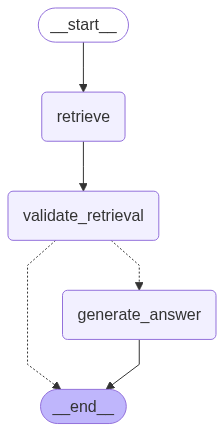

In [34]:
# Use the correct name, IPImage, for displaying in the notebook
display(IPImage(rag_app.get_graph().draw_mermaid_png()))

## 8. Chat with your RAG Agent!

**Purpose**: This is the final, interactive part. You can run this cell multiple times to have a conversation with the agent. It will remember your previous questions.

In [35]:
import langchain

langchain.debug=True

In [30]:
# Generate a unique thread ID for this conversation session
thread_config = {"configurable": {"thread_id": str(uuid.uuid4())}}

while True:
    # Prompt user for a question or exit command
    user_input = input("Ask a question about the images (or type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break  # Exit the loop and end the program

    print("\n--- Invoking Agent ---")

    # Prepare the initial input with the user's message wrapped as a HumanMessage
    initial_input = {"messages": [HumanMessage(content=user_input)]}

    # Stream the response from the RAG agent app
    events = rag_app.stream(
        initial_input,
        thread_config,
        stream_mode="values",  # Stream output values as they arrive
    )

    final_state = None
    # Iterate over streamed events to get the final state after completion
    for event in events:
        final_state = event

    if final_state:
        # Extract the final answer text from the last message
        final_answer = final_state["messages"][-1].content

        # Display the AI's answer formatted as Markdown
        display(Markdown("### Agent's Answer"))
        display(Markdown(final_answer))

        # If there are retrieved images, display them below the answer
        if final_state.get("retrieved_images"):
            display(Markdown("\n**Retrieved Images:**"))
            for img_path in final_state['retrieved_images']:
                try:
                    # Attempt to display each retrieved image with width=200px
                    #display(IPImage(filename=img_path, width=200))
                    pass
                except Exception as e:
                    # Handle any errors loading or displaying the image
                    print(f"Could not display image {img_path}: {e}")

    # Print a visual separator before the next query
    print("\n" + "="*50 + "\n")


Ask a question about the images (or type 'exit' to quit): quit

--- Invoking Agent ---


NameError: name 'rag_app' is not defined